In [351]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Full signal correlations

In [352]:
sid = 'W1'
cell = 'C3'

In [353]:
def plot_channels(data, time, channels, limit = None):
    figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.75 * len(channels)))
    plt.subplots_adjust(
        left = 0.1,
        bottom = 0.1,
        right = 0.9,
        top = 0.9,
        wspace = 0,
        hspace = 0
    )

    x = time

    for i, channel in enumerate(channels):
        y = data[:, i]
        axes[i].plot(x, y, linewidth = 0.5, color = 'black')

        if limit is not None:
            axes[i].set_ylim(-limit, limit)

        axes[i].set_xlim(0, 10)
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
        axes[i].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')

        if i != 0:
            axes[i].spines['top'].set_visible(False)

        if i != len(channels) - 1:
            axes[i].spines['bottom'].set_visible(False)

    plt.show()

In [354]:
with open(f'output/spontaneous-movement/{sid}/{cell}/vm/filter.pkl', 'rb') as file:
    raw = pickle.load(file)

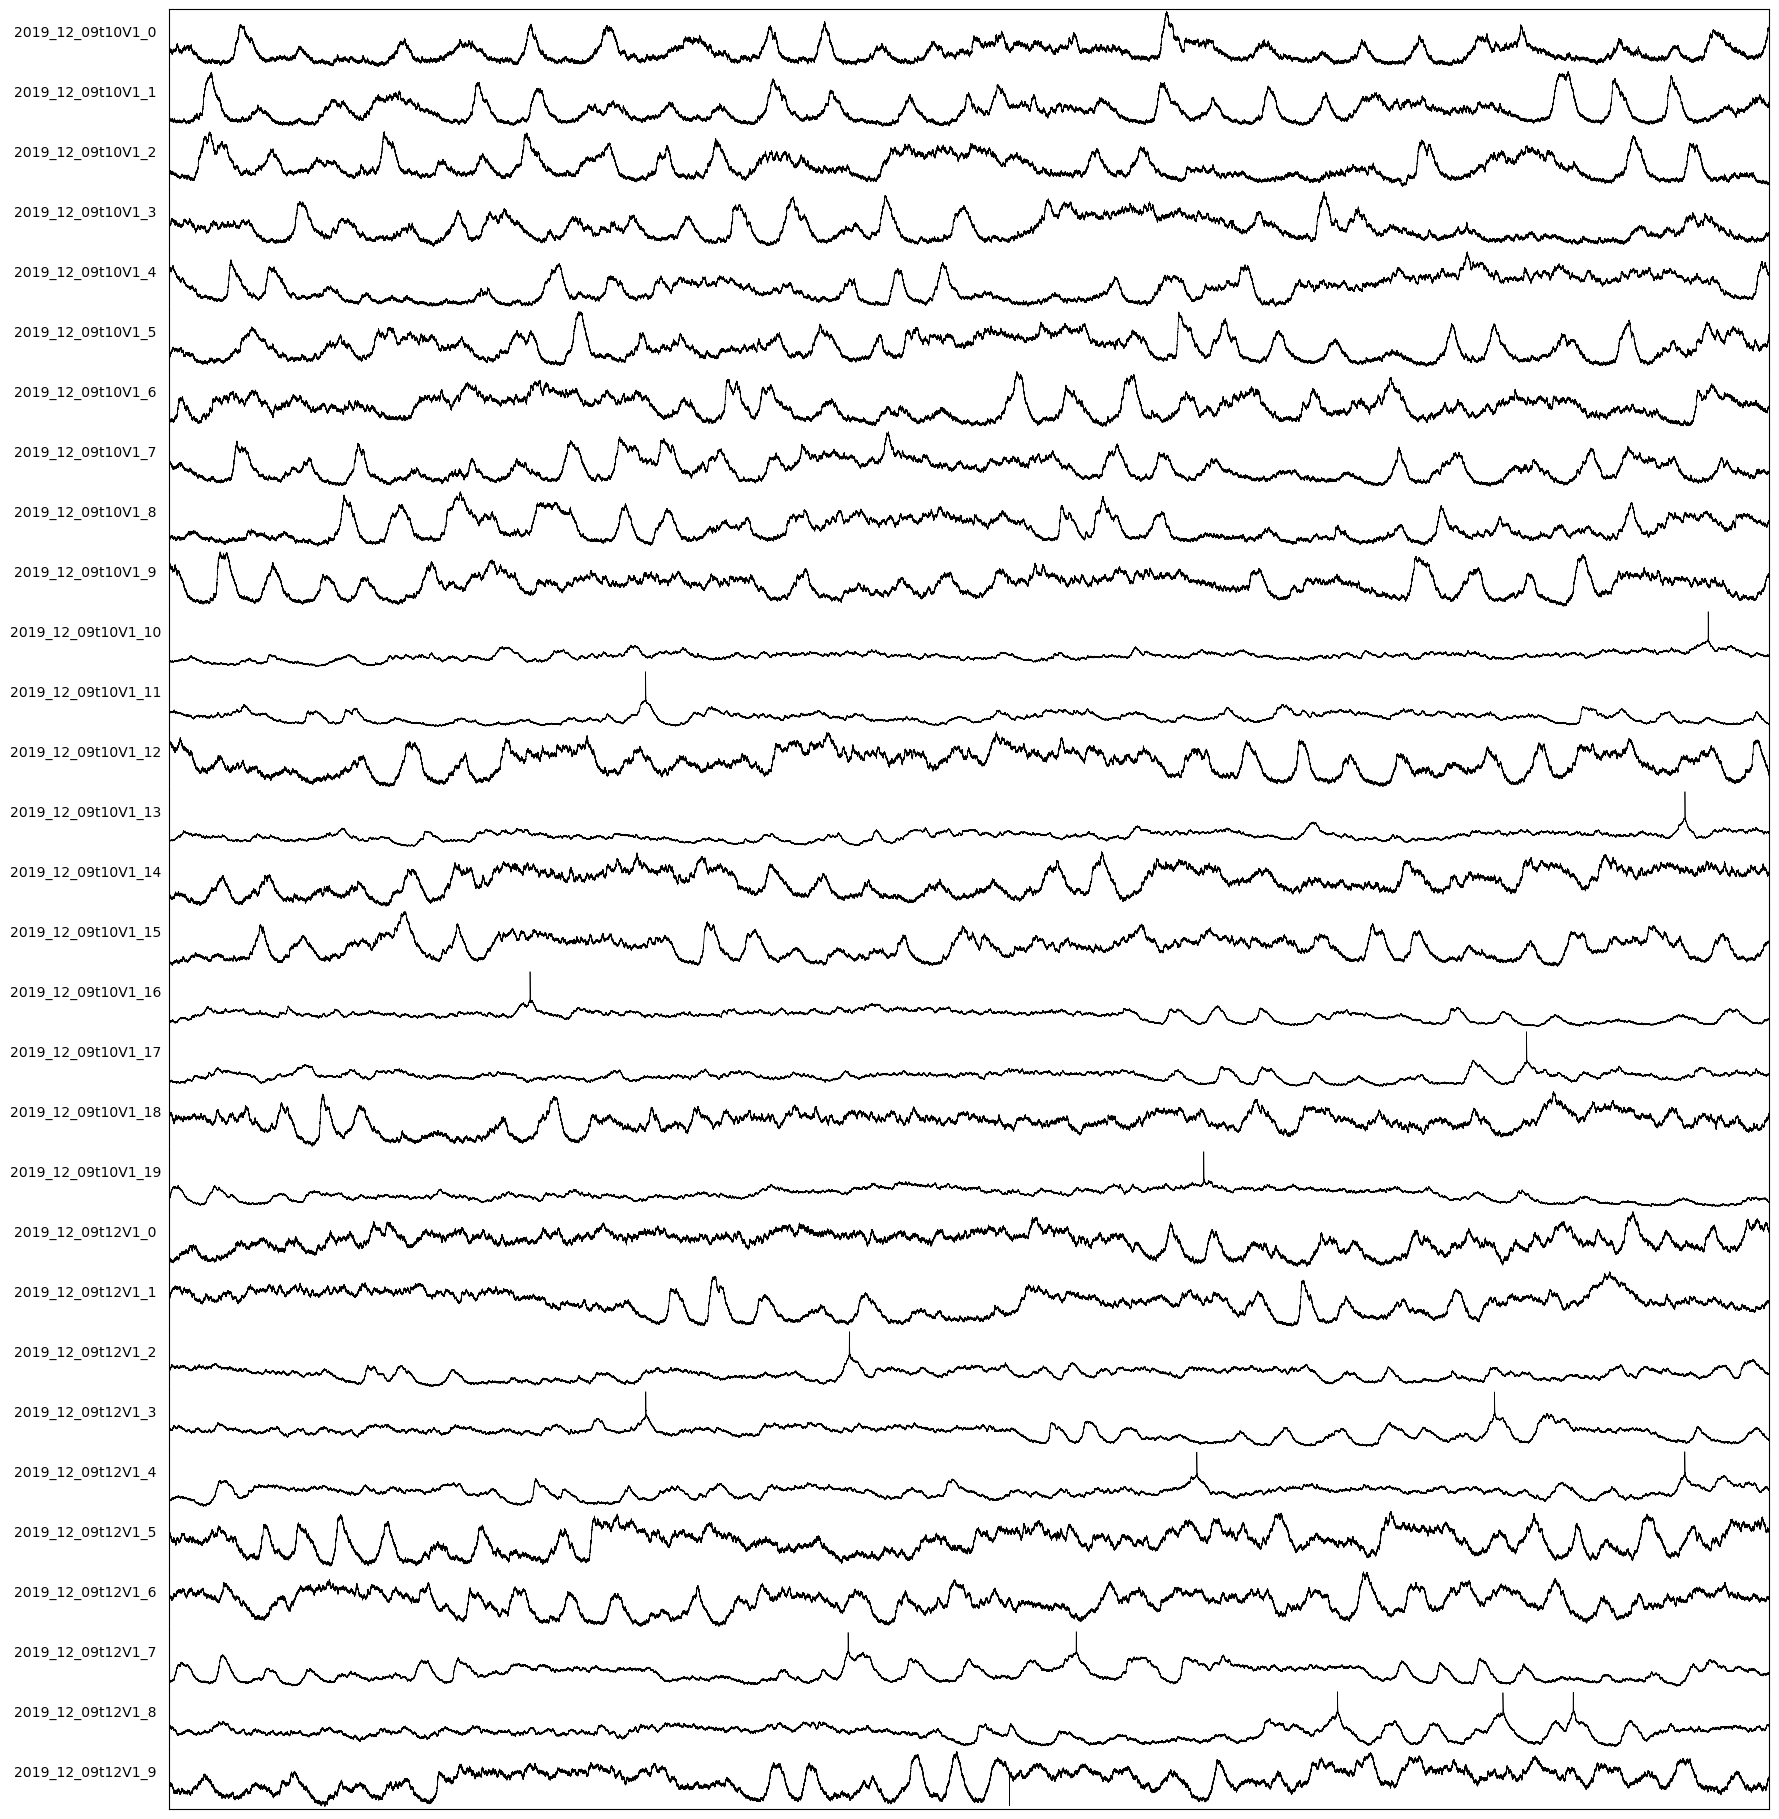

In [355]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = raw.ch_names)

In [356]:
with open(f'output/spontaneous-movement/{sid}/{cell}/emg/filter.pkl', 'rb') as file:
    emg = pickle.load(file)

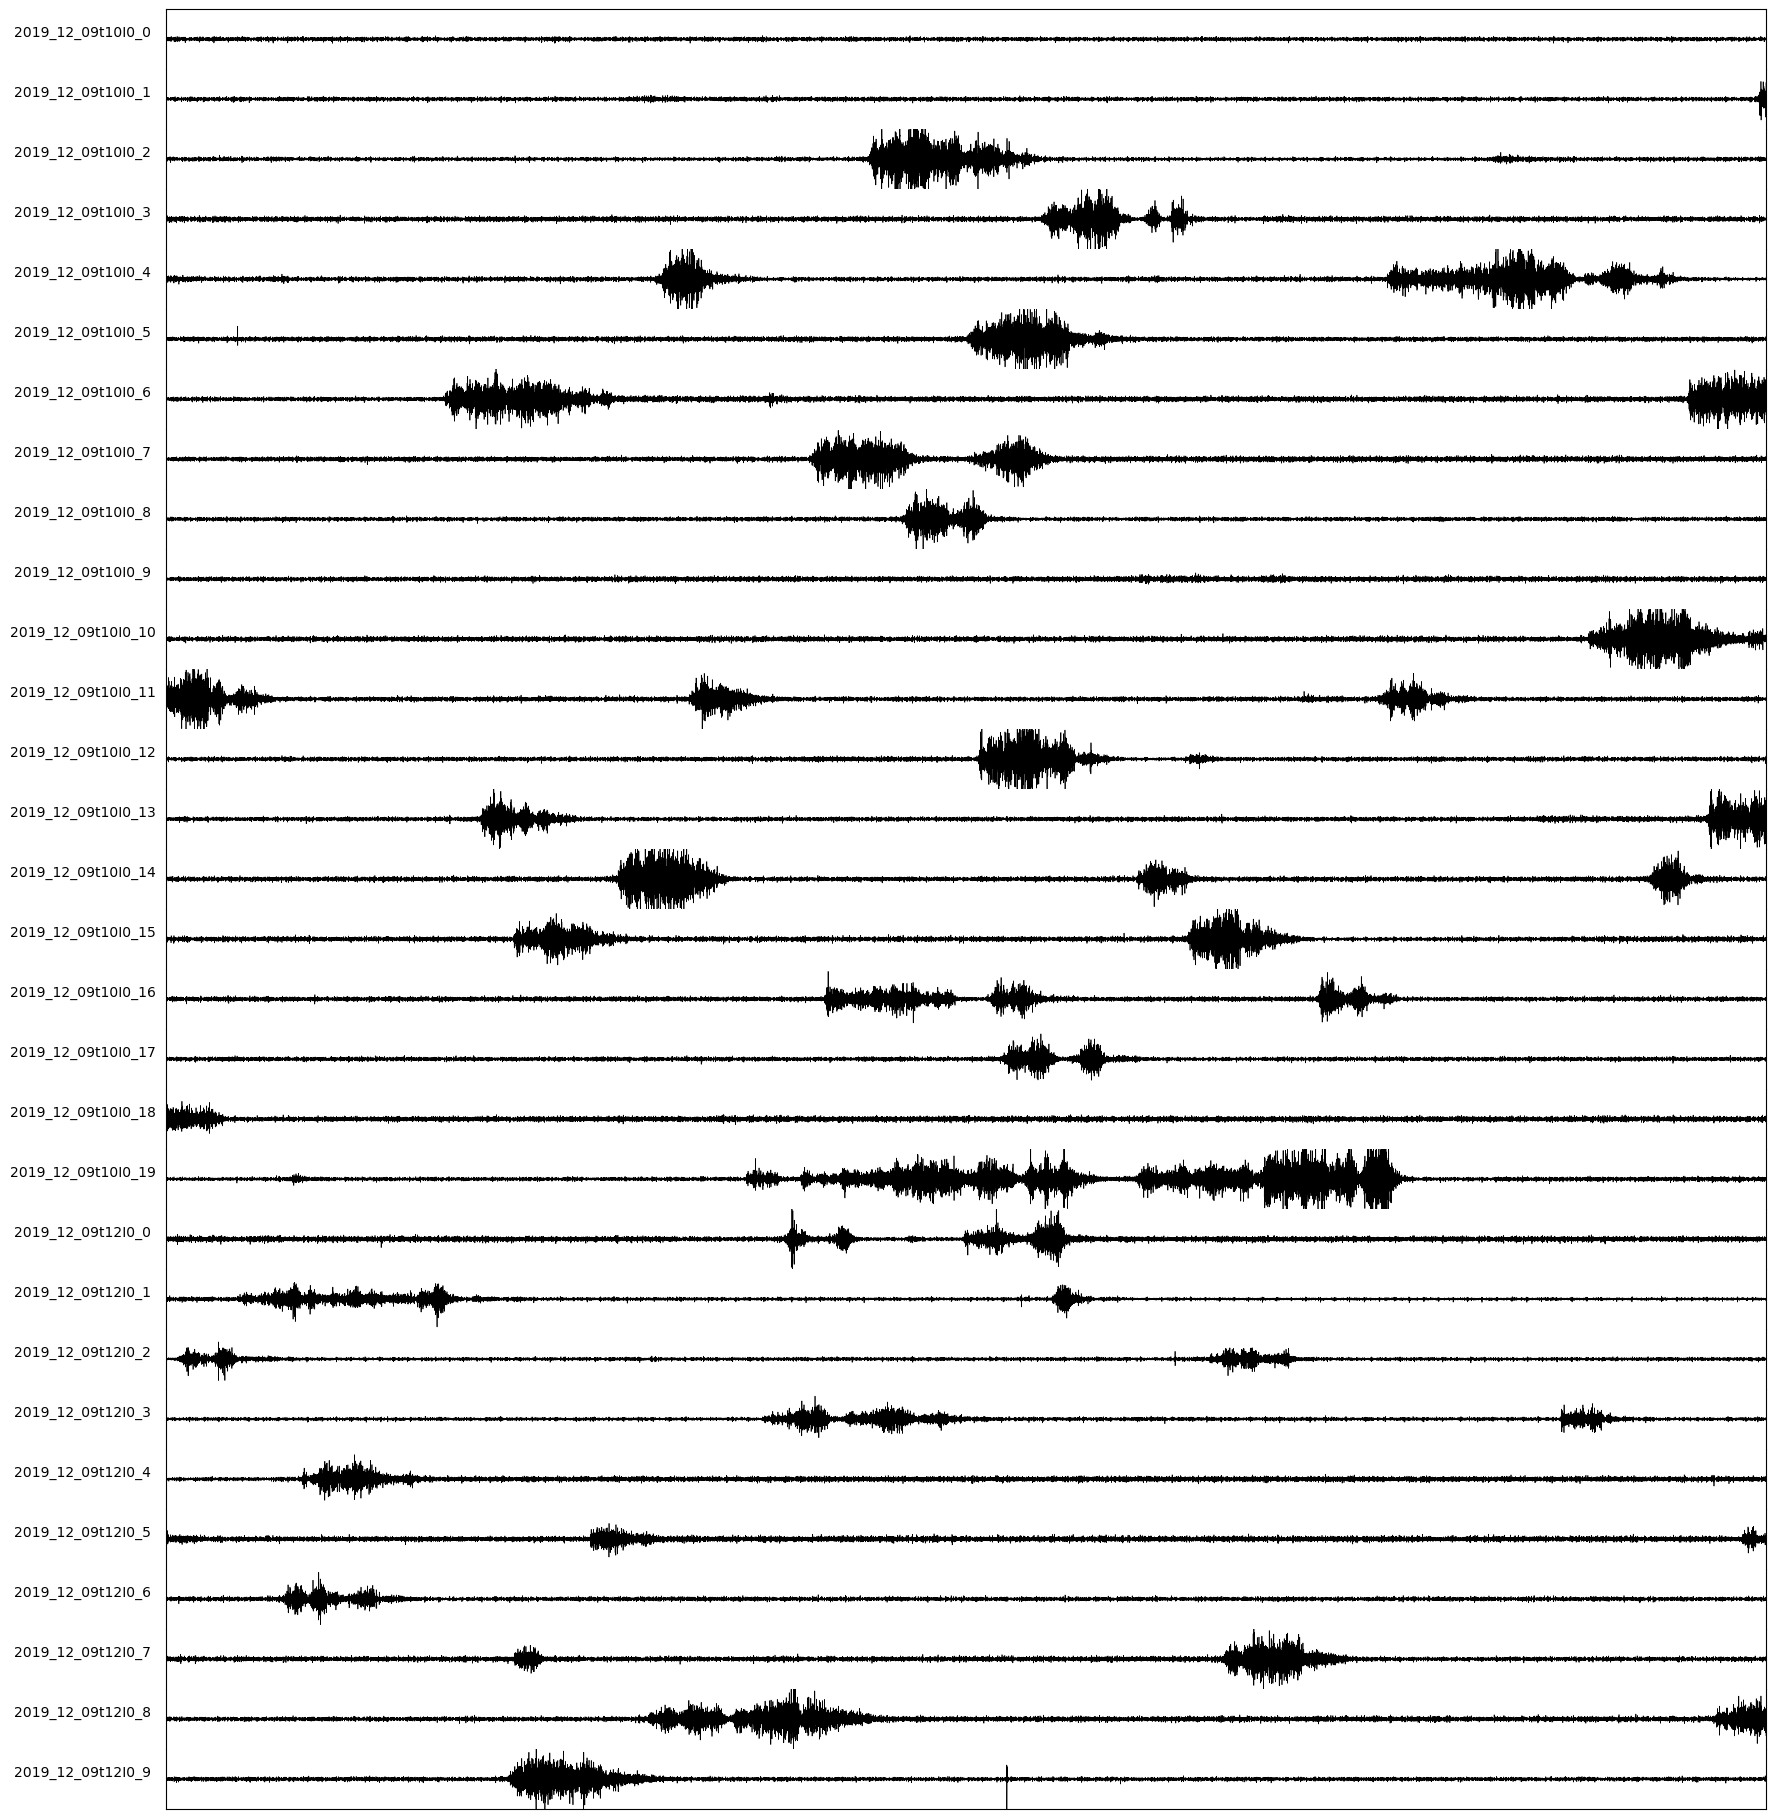

In [357]:
plot_channels(data = emg.get_data().T, time = emg.times, channels = emg.ch_names, limit = 4)

In [358]:
emg_channel = emg.ch_names[14]
vm_channel = raw.ch_names[14]

print(f'{emg_channel} {vm_channel}')

emg_data = emg.copy().pick(picks = [emg_channel]).get_data()[0]
scaled_emg_data = (emg_data - np.mean(emg_data)) / np.std(emg_data)
scaled_emg_data = scaled_emg_data / np.max(np.abs(scaled_emg_data))

vm_data = raw.copy().pick(picks = [vm_channel]).get_data()[0]
scaled_vm_data = vm_data - np.mean(vm_data)
scaled_vm_data = scaled_vm_data / np.max(np.abs(scaled_vm_data))

2019_12_09t10I0_14 2019_12_09t10V1_14


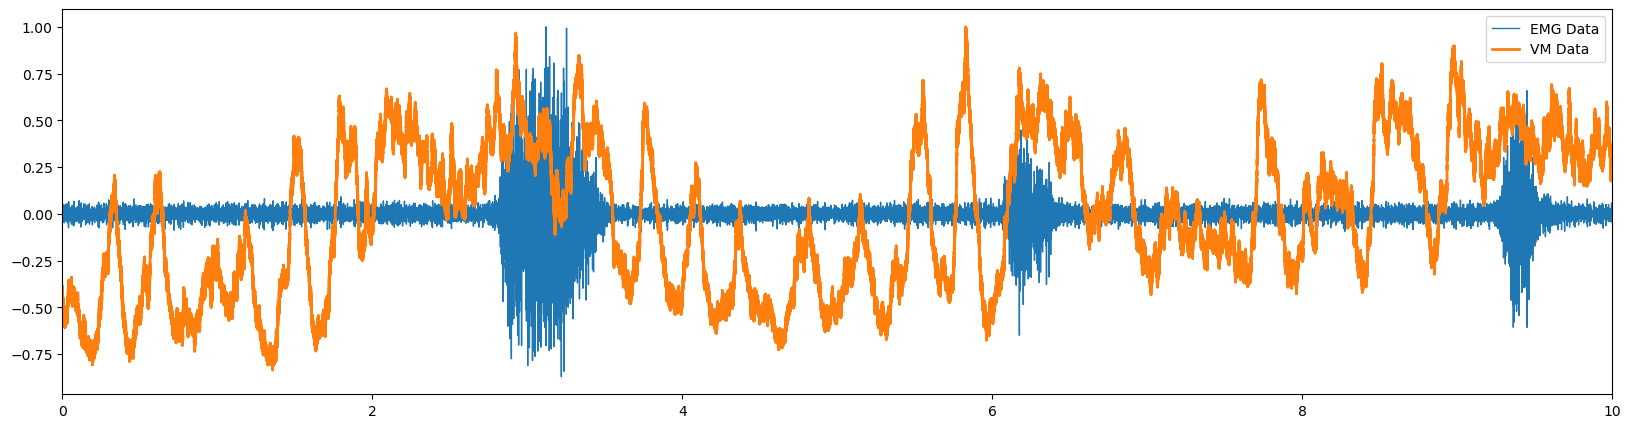

In [359]:
plt.figure(figsize = (20, 5))
plt.plot(emg.times, scaled_emg_data, label = 'EMG Data', linewidth = 1)
plt.plot(raw.times, scaled_vm_data, label = 'VM Data', linewidth = 2)
plt.xlim(0, 10)
plt.legend()
plt.show()

In [360]:
# The second signal (vm_data) is being lagged with respect to the first signal (emg_data).
# Specifically, vm_data is shifted through all possible lags relative to emg_data,
# and the cross-correlation values are calculated for each lag.
correlations = np.correlate(scaled_emg_data, scaled_vm_data, mode = 'full')

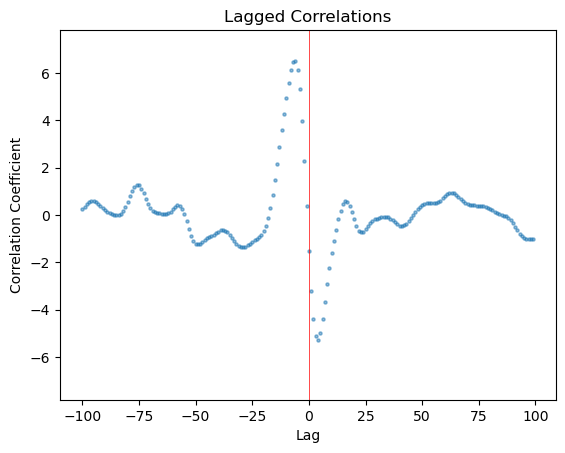

In [361]:
max_lag_dev = 0.005 # s
max_lag_points = int(max_lag_dev * raw.info['sfreq'])

# Generate lag values corresponding to the correlations
lags = np.arange(-len(emg_data) + 1, len(emg_data))
middle = np.where(lags == 0)[0][0]

x = lags[(middle - max_lag_points):(middle + max_lag_points)]
y = correlations[(middle - max_lag_points):(middle + max_lag_points)]

# Plot the lagged correlations
plt.scatter(x, y, s = 5, alpha = 0.5)
plt.title('Lagged Correlations')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.ylim(-np.max(np.abs(y)) * 1.2, np.max(np.abs(y)) * 1.2)
plt.axvline(x = 0, linewidth = 0.5, color = 'red', linestyle = '-')
plt.show()

# What happens during movements?

In [362]:
with open('python/methods.py', 'r') as file:
    exec(file.read())

In [363]:
vm = read_pickle(f'output/spontaneous-movement/{sid}/{cell}/vm/filter.pkl')
emg = read_pickle(f'output/spontaneous-movement/{sid}/{cell}/emg/filter.pkl')
movement = read_pickle(f'output/spontaneous-movement/{sid}/{cell}/emg/final_movement.pkl')
no_movement = read_pickle(f'output/spontaneous-movement/{sid}/{cell}/emg/all_no_movement.pkl')

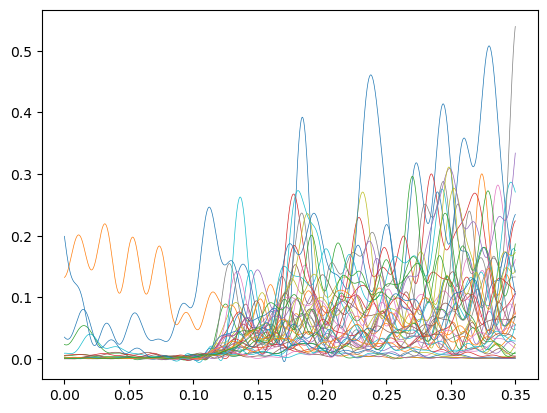

In [364]:
tkeo_data = calculate_tkeo(emg, h_freq = 50)

for index, event in movement.iterrows():
    start = event['Start'] - 0.1
    end = np.min([start + 0.35, 10])
    channel = event['Channel']

    dt = tkeo_data.copy().pick(picks = [channel]).crop(tmin = start, tmax = end)
    x = dt.times
    y = dt.get_data()[0]

    plt.plot(x, y, linewidth = 0.5)

plt.show()

The importance of filtering the events properly... :) Seems like will have to go over the event detection and filtering algorithm and drop events with unclear starting phase.

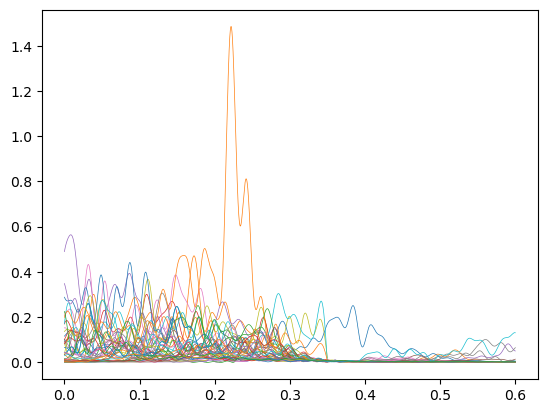

In [365]:
for index, event in movement.iterrows():
    end = event['End']
    start = end - 0.35
    end = np.min([end + 0.25, np.max(tkeo_data.times)])
    channel = event['Channel']

    dt = tkeo_data.copy().pick(picks = [channel]).crop(tmin = start, tmax = end)
    x = dt.times
    y = dt.get_data()[0]
    # y = y / np.max(y)

    plt.plot(x, y, linewidth = 0.5)

plt.show()

Some events have relatively unclear ending phases as well.

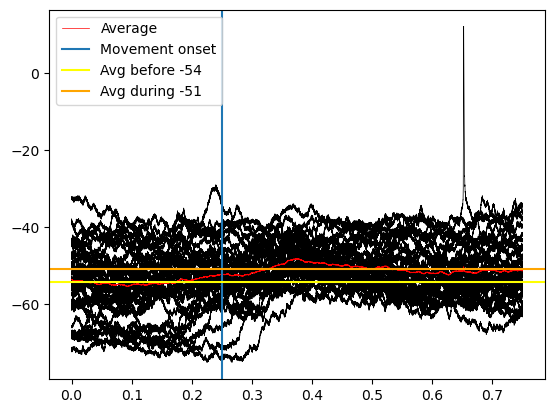

In [366]:
ys = []
for index, event in movement.iterrows():
    start = event['Start']
    end = start + 0.5
    start = start - 0.25

    if end > np.max(emg.times): continue

    channel = event['Channel']
    channel_i = [i for i, ch in enumerate(emg.ch_names) if ch == channel][0]

    dt = vm.copy().pick(picks = [channel_i]).crop(tmin = start, tmax = end)
    x = dt.times
    y = dt.get_data()[0]
    ys.append(y)

    plt.plot(x, y, linewidth = 0.5, color = 'black')

onset = int(0.25 * vm.info['sfreq'])
ys = np.array(ys)
y = np.mean(ys, axis = 0)
plt.plot(x, y, linewidth = 0.5, color = 'red', label = 'Average')
plt.axvline(x = 0.25, label = 'Movement onset')
plt.axhline(y = np.mean(y[ :onset ]), label = f'Avg before {round(np.mean(y[ :onset ]))}', color = 'yellow')
plt.axhline(y = np.mean(y[ onset: ]), label = f'Avg during {round(np.mean(y[ onset: ]))}', color = 'orange')
plt.legend()
plt.show()

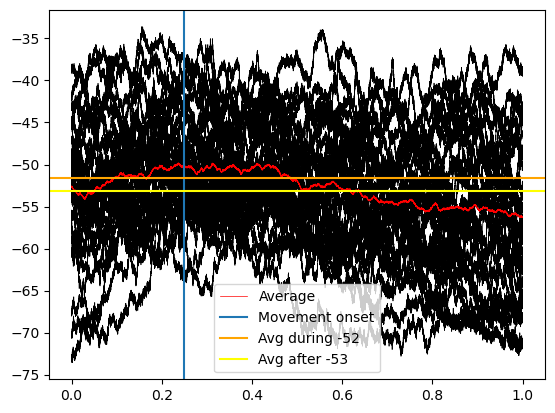

In [367]:
ys = []
for index, event in movement.iterrows():
    end = event['End']
    start = end - 0.5
    end = end + 0.5

    if end > np.max(emg.times): continue

    channel = event['Channel']
    channel_i = [i for i, ch in enumerate(emg.ch_names) if ch == channel][0]

    dt = vm.copy().pick(picks = [channel_i]).crop(tmin = start, tmax = end)
    x = dt.times
    y = dt.get_data()[0]
    ys.append(y)

    plt.plot(x, y, linewidth = 0.5, color = 'black')

onset = int(0.25 * vm.info['sfreq'])
ys = np.array(ys)
y = np.mean(ys, axis = 0)
plt.plot(x, y, linewidth = 0.5, color = 'red', label = 'Average')
plt.axvline(x = 0.25, label = 'Movement onset')
plt.axhline(y = np.mean(y[ :onset ]), label = f'Avg during {round(np.mean(y[ :onset ]))}', color = 'orange')
plt.axhline(y = np.mean(y[ onset: ]), label = f'Avg after {round(np.mean(y[ onset: ]))}', color = 'yellow')
plt.legend()
plt.show()

Seems like the signal is a bit more depolarized during movement.

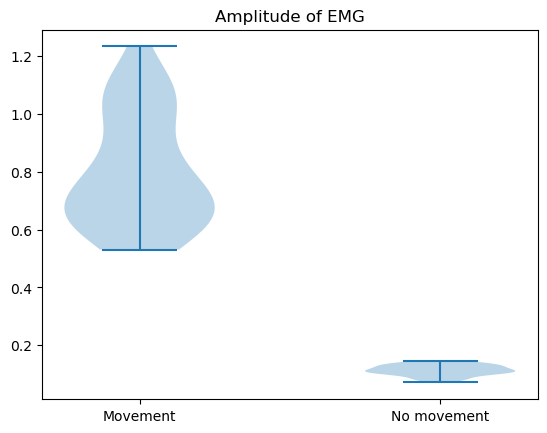

In [368]:
plt.violinplot([movement['Amplitude'], no_movement['Amplitude']])
plt.xticks([1, 2], ['Movement', 'No movement'])
plt.title('Amplitude of EMG')
plt.show()

In [369]:
for index, event in movement.iterrows():
    start = event['Start']
    end = event['End']
    channel = event['Channel']
    channel_i = [i for i, ch in enumerate(emg.ch_names) if ch == channel][0]
    dt = vm.copy().pick(picks = [channel_i]).crop(tmin = start, tmax = end).get_data()[0]
    movement.at[index, 'VM Amplitude'] = np.sqrt(np.mean(np.square(dt)))
    movement.at[index, 'VM Max'] = np.max(dt)
    movement.at[index, 'VM Min'] = np.min(dt)
    movement.at[index, 'VM SD'] = np.std(dt)
    movement.at[index, 'VM Mean'] = np.mean(dt)

for index, event in no_movement.iterrows():
    start = event['Start']
    end = event['End']
    channel = event['Channel']
    channel_i = [i for i, ch in enumerate(emg.ch_names) if ch == channel][0]
    dt = vm.copy().pick(picks = [channel_i]).crop(tmin = start, tmax = end).get_data()[0]
    no_movement.at[index, 'VM Amplitude'] = np.sqrt(np.mean(np.square(dt)))
    no_movement.at[index, 'VM Max'] = np.max(dt)
    no_movement.at[index, 'VM Min'] = np.min(dt)
    no_movement.at[index, 'VM SD'] = np.std(dt)
    no_movement.at[index, 'VM Mean'] = np.mean(dt)

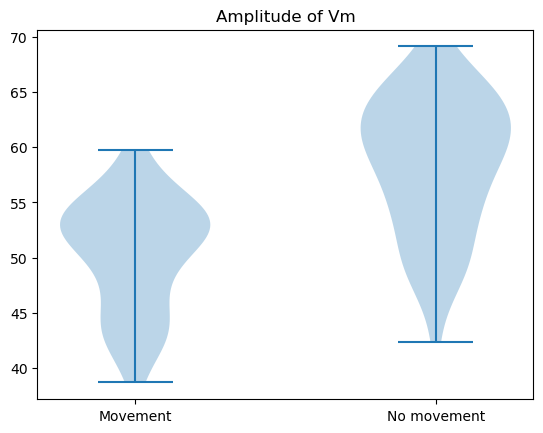

In [370]:
plt.violinplot([movement['VM Amplitude'], no_movement['VM Amplitude']])
plt.xticks([1, 2], ['Movement', 'No movement'])
plt.title('Amplitude of Vm')
plt.show()

In [371]:
dt_move = pd.DataFrame({
    'Amplitude': movement['VM Amplitude'],
    'Max': movement['VM Max'],
    'Min': movement['VM Min'],
    'SD': movement['VM SD'],
    'Mean': movement['VM Mean'],
    'Type': 1
})

dt_no_move = pd.DataFrame({
    'Amplitude': no_movement['VM Amplitude'],
    'Max': no_movement['VM Max'],
    'Min': no_movement['VM Min'],
    'SD': no_movement['VM SD'],
    'Mean': no_movement['VM Mean'],
    'Type': 2
})

dt = pd.concat([dt_move, dt_no_move], ignore_index = True)

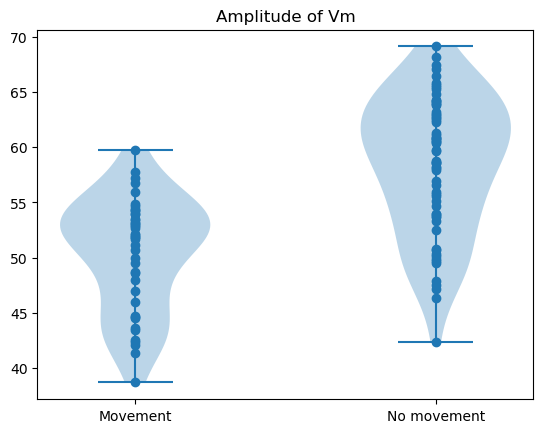

T-statistic: -7.122835574623036
P-value: 1.2806143724346843e-10


In [372]:
movement_amplitudes = dt[dt['Type'] == 1]['Amplitude']
no_movement_amplitudes = dt[dt['Type'] == 2]['Amplitude']

t_statistic, p_value = ttest_ind(movement_amplitudes, no_movement_amplitudes)

plt.violinplot([movement['VM Amplitude'], no_movement['VM Amplitude']])
plt.scatter(dt['Type'], dt['Amplitude'])
plt.title(f'Amplitude of Vm')
plt.xticks([1, 2], ['Movement', 'No movement'])
plt.show()

print("T-statistic:", t_statistic)
print("P-value:", p_value)

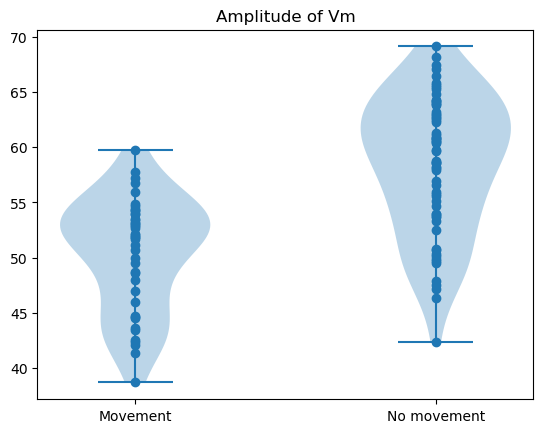

T-statistic: -7.122835574623036
P-value: 1.2806143724346843e-10


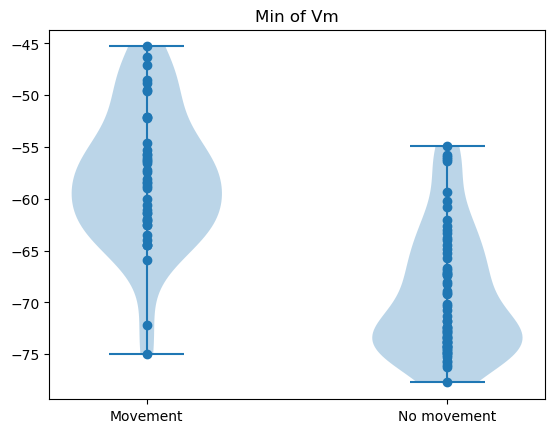

T-statistic: 9.290760106641812
P-value: 2.055642988542896e-15


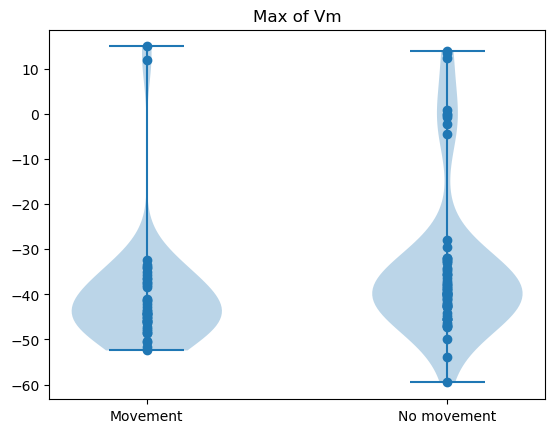

T-statistic: -2.0417478780755305
P-value: 0.04363649084541462


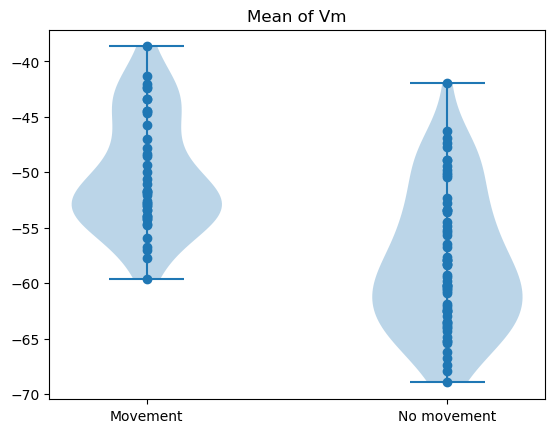

T-statistic: 6.896899898286966
P-value: 3.8711435797784626e-10


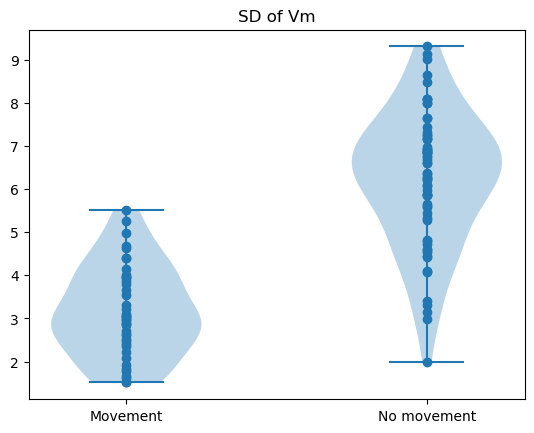

T-statistic: -11.35758494933121
P-value: 4.3242548637335606e-20


In [373]:
for variable in ['Amplitude', 'Min', 'Max', 'Mean', 'SD']:
    movement_data = dt[dt['Type'] == 1][variable]
    no_movement_data = dt[dt['Type'] == 2][variable]
    
    t_statistic, p_value = ttest_ind(movement_data, no_movement_data)
    
    plt.violinplot([movement[f'VM {variable}'], no_movement[f'VM {variable}']])
    plt.scatter(dt['Type'], dt[f'{variable}'])
    plt.title(f'{variable} of Vm')
    plt.xticks([1, 2], ['Movement', 'No movement'])
    plt.show()
    
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)